#Train, validation and test data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ova vizualizacija prikazuje raspodjelu slika po klasama i podjelu na trening, validaciju i test skupove. Cilj je potvrditi da su podaci pravilno razdvojeni i da su svi skupovi proporcionalno zastupljeni, čime se osigurava pouzdana evaluacija modela.

<Axes: >

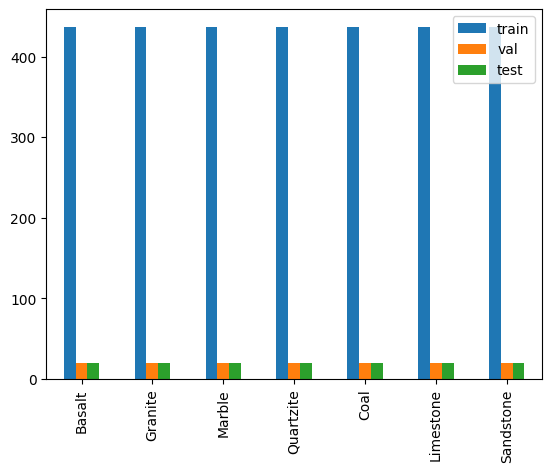

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/output/"

img_data = {}

for folder in os.listdir(OUTPUT_DIR):
    subfolder_path = OUTPUT_DIR + folder + '/'
    img_data[folder] = {}
    for subfolder in os.listdir(subfolder_path):
        img_data[folder][subfolder] = len(os.listdir(subfolder_path + subfolder))

df = pd.DataFrame.from_dict(img_data, orient='index')
df.T.plot(kind='bar')

Podaci su transformisani i učitani u treniranje, validaciju i testiranje uz normalizaciju i ujednačavanje dimenzija slika.

In [ ]:
im_size = 224
transformation = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(im_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

 # Load data
train_data = datasets.ImageFolder(
    OUTPUT_DIR + "train", transform=transformation
)
val_data = datasets.ImageFolder(
    OUTPUT_DIR + "val", transform=transformation
)
test_data = datasets.ImageFolder(
    OUTPUT_DIR + "test", transform=transformation
)

# Creating data samplers and loaders:
BATCH_SIZE = 20
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False
)

# Label mapping
class_mapping = train_data.class_to_idx

Ova funkcija izračunava ukupni gubitak i tačnost modela na validacionom skupu pomoću predikcija i stvarnih oznaka.

In [ ]:
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy


Ova funkcija trenira model kroz zadani broj epoha koristeći trenirajući skup podataka, prati prosječni gubitak po epohi i istovremeno vrši evaluaciju modela na validacionom skupu kako bi izračunala prosječni gubitak i tačnost.

In [ ]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    import torch
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for e in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        validation_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                validation_loss += val_loss.item()

                _, val_preds = torch.max(val_outputs, 1)
                correct_val += (val_preds == val_labels).sum().item()
                total_val += val_labels.size(0)

        avg_val_loss = validation_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc / 100)
        val_accuracies.append(val_acc / 100)

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Training Loss: {avg_train_loss:.3f}.. "
            f"Validation Loss: {avg_val_loss:.3f}.. "
            f"Validation Accuracy: {val_acc:.2f}%"
        )

    # === Grafički prikaz ===
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # (a) Gubitak
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
    plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.text(0.5, -0.2, '(a) Prikaz vrijednosti funkcije gubitka.', ha='center', va='center', transform=plt.gca().transAxes)

    # (b) Tačnost
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'bo', label='Training acc')
    plt.plot(epochs_range, val_accuracies, 'b', label='Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.text(0.5, -0.2, '(b) Prikaz tačnosti modela.', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Opcionalno snimanje slike (poništi komentar ako ti treba)
    # plt.savefig("grafici_treninga.png", dpi=300, bbox_inches='tight')

    return model


Ova funkcija čuva trenirani model na disk tako što snima njegovu arhitekturu, mapiranje klasa i naučene težine u datoteku sa vremenskom oznakom, omogućavajući kasnije učitavanje i upotrebu bez ponovnog treniranja.

In [ ]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/checkpoint/{timestamp}_{arch}.pth")

Ova linija učitava unaprijed trenirani ResNet-50 model iz PyTorch biblioteke, koji se koristi kao osnovna arhitektura za prijenos učenja u zadatku klasifikacije.

In [ ]:
model = models.resnet50(weights=True)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Ovdje se zamrzavaju svi slojevi unaprijed treniranog modela ResNet-50 kako bi se spriječilo njihovo treniranje, a zatim se zamjenjuje njegov završni sloj novim klasifikatorom prilagođenim broju klasa u skupu podataka, čime se model prilagođava specifičnom zadatku klasifikacije stijena.

In [ ]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

In [ ]:
print("Original final layer")
print(model.fc)

# Build custom classifier
num_classes = len(class_mapping)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

print("\nModified final layer")
print(model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=7, bias=True)
  (output): LogSoftmax(dim=1)
)


#####Ovdje se definiše funkcija gubitka NLLLoss (Negative Log-Likelihood) koja je pogodna za klasifikacione zadatke s log-softmax izlazom, te se inicijalizira Adam optimizator koji ažurira samo parametre finalnog sloja modela uz zadanu stopu učenja.

In [ ]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Epoch: 1/20.. Training Loss: 1.328.. Validation Loss: 1.076.. Validation Accuracy: 62.86%
Epoch: 2/20.. Training Loss: 0.979.. Validation Loss: 0.957.. Validation Accuracy: 65.00%
Epoch: 3/20.. Training Loss: 0.891.. Validation Loss: 0.995.. Validation Accuracy: 70.71%
Epoch: 4/20.. Training Loss: 0.822.. Validation Loss: 0.905.. Validation Accuracy: 70.71%
Epoch: 5/20.. Training Loss: 0.796.. Validation Loss: 0.992.. Validation Accuracy: 69.29%
Epoch: 6/20.. Training Loss: 0.745.. Validation Loss: 0.897.. Validation Accuracy: 70.00%
Epoch: 7/20.. Training Loss: 0.671.. Validation Loss: 0.935.. Validation Accuracy: 67.14%
Epoch: 8/20.. Training Loss: 0.686.. Validation Loss: 0.914.. Validation Accuracy: 71.43%
Epoch: 9/20.. Training Loss: 0.701.. Validation Loss: 0.968.. Validation Accuracy: 66.43%
Epoch: 10/20.. Training Loss: 0.679.. Validation Loss: 0.914.. Validation Accuracy: 62.14%
Epoch: 11/20.. Training Loss: 0.633.. Validation Loss: 0.910.. Validation Accuracy: 65.00%
Epoch: 1

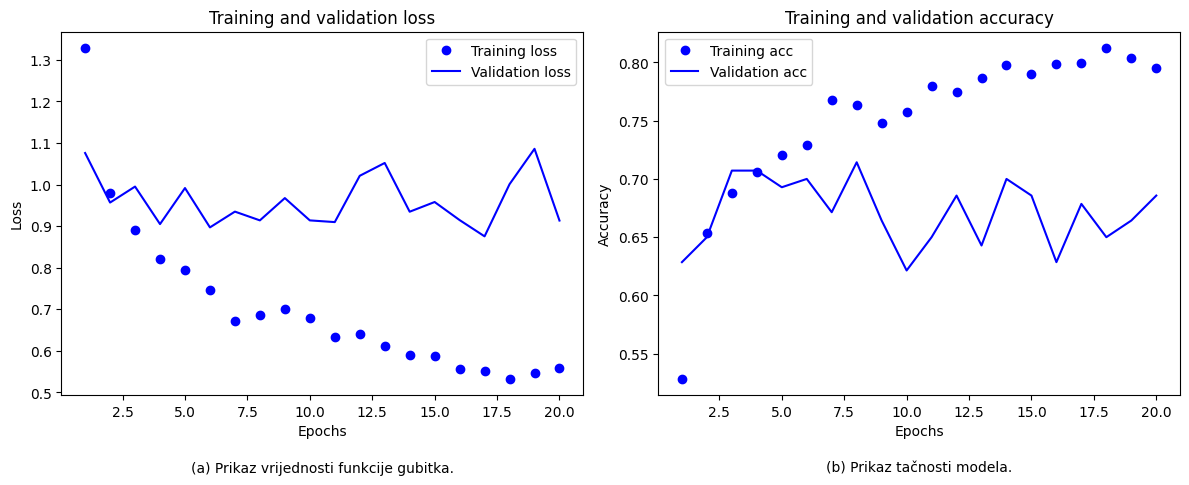

In [ ]:
# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

Ova ćelija demonstrira kako učitati pojedinačnu sliku, pripremiti je pomoću transformacija, te izvršiti predikciju klase koristeći prethodno istrenirani model – pri čemu se rezultat prikazuje kao naziv pripadajuće klase iz skupa.

In [ ]:
save_checkpoint(resnet_model, class_mapping, 'resnet50')

In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from PIL import Image
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Učitaj checkpoint
checkpoint_path = '/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/checkpoint/20250531_resnet50.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Rekonstruiši model sa identičnom fc strukturom kao pri treniranju
model = models.resnet50(pretrained=False)
model.fc = nn.Sequential(OrderedDict([
    ('fc', nn.Linear(model.fc.in_features, 7))  # 7 klasa
]))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Učitaj klase iz test foldera
data_dir = '/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/output/test'
full_dataset = datasets.ImageFolder(data_dir)
class_names = full_dataset.classes
print(f'Klase: {class_names}')

# Učitaj i pripremi sliku
image_path = '/content/sandstone.PNG'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Predikcija
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

print(f'Ova slika je predviđena kao: {class_names[predicted_class.item()]}')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Klase: ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


FileNotFoundError: [Errno 2] No such file or directory: '/content/sandstone.PNG'